### KEGG

In [ ]:
import os
import pandas as pd
import numpy as np
import json
import re

In [ ]:
### JSON to dict
with open('/mnt/data1/wangj/GeneSets/hsa00001.json','r') as file:
    json_str = file.read()

In [ ]:
data_dict = json.loads(json_str)

In [ ]:
with open('/mnt/data1/wangj/GeneSets/KEGG.gmt','w') as file:
    for i in range(0,8):
        collection = data_dict['children'][i]['children']
        for j in range(len(collection)):
            # set_N = re.findall(re.compile(r'\d+ (.*)'),collection[j]['name'])[0]
            subcollection = collection[j]['children']
            for k in range(len(subcollection)):
                name = subcollection[k]['name']
                try:
                    KEGG_ID = re.findall(re.compile(r'(hsa\d+)'),name)[0]
                    KEGG_Name = 'KEGG_' + re.findall(re.compile(r'\d+ (.*) \['),name)[0]
                    file.write(KEGG_Name+'\t'+KEGG_ID+'\t')
                    genes = subcollection[k]['children']
                    for gene in genes:
                        file.write(gene['name'].split(' ')[1].replace(';','')+'\t')
                    file.write('\n')
                except:
                    pass

In [ ]:
### network plot:KEGG enrichment
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp
import os

os.chdir('/mnt/data1/wangj/AgingScore/GSE163530_COVID-19/GSE171668_scnRNA/')

In [ ]:
degs_up = pd.read_csv('Endo_sense_marker.csv',index_col=0)
enr_KEGG = gp.enrichr(degs_up.index.tolist(),
                    gene_sets='KEGG_2021_Human',
                    outdir=None)
Enrich_KEGG = enr_KEGG.results 
Enrich_KEGG = Enrich_KEGG[Enrich_KEGG['Adjusted P-value']<1]
Enrich_KEGG.shape

In [ ]:
Enrich_KEGG_select = Enrich_KEGG[(Enrich_KEGG.Term.isin(list(filter(lambda x: 'signaling pathway' in x, Enrich_KEGG.Term))))]
Enrich_KEGG_select = Enrich_KEGG_select.sort_values(by='Adjusted P-value',ascending=True,ignore_index=True)
Enrich_KEGG_plot = pd.concat([Enrich_KEGG_select[0:10],Enrich_KEGG[(Enrich_KEGG.Term.isin(['Cellular senescence','Coronavirus disease']))]],ignore_index=True)                       

In [ ]:
nodes, edges = gp.enrichment_map(Enrich_KEGG_plot,cutoff = 0.5,top_term = 20)
nodes.shape

In [ ]:
G = nx.from_pandas_edgelist(edges,
                            source='src_idx',
                            target='targ_idx',
                            edge_attr=['jaccard_coef', 'overlap_coef', 'overlap_genes'])
node_list = sorted(G.nodes())
angle = []
angle_dict = {}
n = nodes.shape[0]
for i, node in zip(range(n),node_list):
    theta = 2.0*np.pi*i/n
    angle.append((np.cos(theta),np.sin(theta)))
    angle_dict[node] = theta
pos = {}
for node_i, node in enumerate(node_list):
    pos[node] = angle[node_i]

labels = nodes.Term.to_dict()

fig, ax = plt.subplots(figsize=(8,8))
margin=0.33
fig.subplots_adjust(margin, margin, 1.-margin, 1.-margin)
ax.axis('equal')

edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()

net = nx.draw(G,
              pos=pos,
              with_labels=False, 
              ax=ax,
              width=list(map(lambda x: x*10, edge_weight)),
              edge_color='#CDDBD4',
              node_color=list(nodes['Adjusted P-value']),
              node_size=list(nodes.Hits_ratio *3000),
              cmap=plt.cm.RdYlBu)
description = nx.draw_networkx_labels(G,pos,labels=labels,font_size=15)

r = fig.canvas.get_renderer()
trans = plt.gca().transData.inverted()
for node, t in description.items():
    bb = t.get_window_extent(renderer=r)
    bbdata = bb.transformed(trans)
    radius = 1.2+bbdata.width/2.
    position = (radius*np.cos(angle_dict[node]),radius* np.sin(angle_dict[node]))
    t.set_position(position)
    t.set_rotation(angle_dict[node]*360.0/(2.0*np.pi))
    t.set_clip_on(False)
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu, 
                           norm=plt.Normalize(vmin = nodes['Adjusted P-value'].min(), 
                                              vmax=nodes['Adjusted P-value'].max()))
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax_col = fig.add_axes([0.1, 0.04, 0.02, 0.15])
sns.set(font_scale=1)
ax_col.set_title('Adjusted P-value')
plt.colorbar(sm,shrink=0.4,cax=ax_col,orientation='vertical')
plt.savefig("/home/wangjing/wangj/codebase/HUSI/Figures/covid-19/Endo_state_KEGGenrich.png",dpi = 200,bbox_inches = 'tight')
plt.show()

### GTEx

In [11]:
import senepy as sp
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sci
import numpy as np

In [3]:
# gtex_raw = sc.read("/mnt/data1/wangj/MyProject/Data/GTEx/Bulk_SnRNA/GTEx_8_tissues_snRNAseq_atlas_071421.public_obs.h5ad")
gtex = gtex_raw.raw.to_adata()
gtex 

AnnData object with n_obs × n_vars = 209126 × 33694
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', 'gene_biotype', 'gene_length', 'gene_coding_length', 'Approved symbol', '

/home/wangjing/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_c

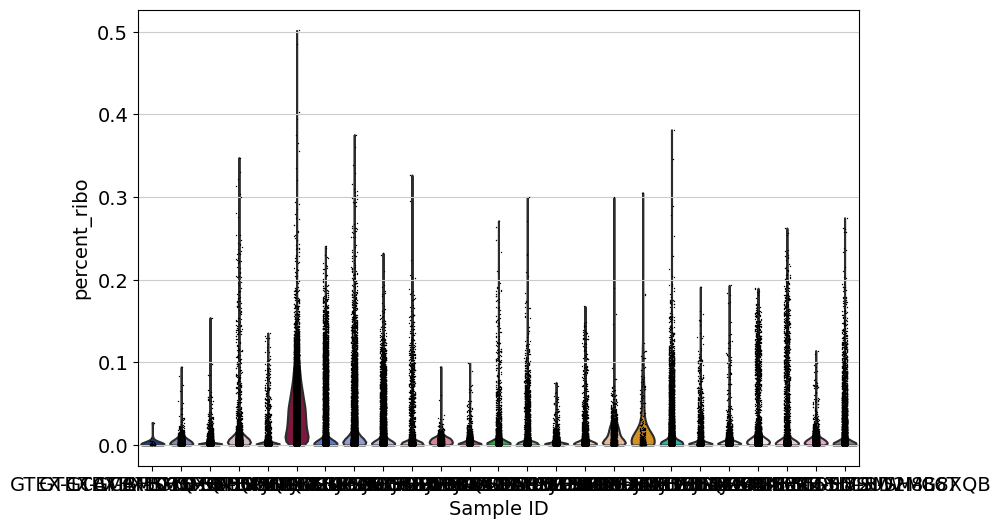

In [4]:
### remove cells with high ribosome gene expression
gtex.obs['percent_ribo'] = gtex.X[:,(gtex.var_names.str.startswith('RPS') | gtex.var_names.str.startswith('RPL'))].sum(axis=1).flatten().tolist()[0]/gtex.obs['nUMIs']
sc.set_figure_params(dpi=50, color_map='viridis',figsize=(8,6))
sc.pl.violin(gtex, ['percent_ribo'], groupby='Sample ID')

In [5]:
gtex = gtex[gtex.obs['percent_ribo']<0.05,:]
gtex

/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


View of AnnData object with n_obs × n_vars = 195741 × 33694
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel', 'percent_ribo'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', 'gene_biotype', 'gene_length', 'gene_coding_lengt

In [6]:
mm_l2 = pd.read_csv('/home/wangjing/wangj/AgingScore/AgingScorePro/l2.csv',index_col=0)

In [7]:
hubs = sp.load_hubs(species = 'Human')

In [8]:
### load the match Cell type
cell_map = pd.read_csv('/home/wangjing/wangj/codebase/HUSI/GTEx_SenePy.csv')
cell_map

,GTEx,Tissue_1,SenePy,Tissue_2
0,Endothelial cell (vascular);Endothelial cell (...,Lung,endothelial cell,lung
1,Epithelial cell (basal),Lung,basal cell,lung
2,Epithelial cell (ciliated),Lung,ciliated epithelial cell,lung
3,Epithelial cell (club),Lung,club cell,lung
4,Fibroblast,Lung,fibroblast,lung
5,Immune (DC/macrophage);Immune (DC/macrophage),Lung,macrophage,lung
6,Immune (T cell),Lung,t cell,lung
7,Epithelial cell (alveolar type II),Lung,type ii pneumocyte,lung
8,Myocyte (cardiac),Heart,cardiomyocyte,heart
9,Adipocyte,Heart,adipocyte,heart


In [9]:
### subset gext data
cell_use = {}
cell_uses = []
meta = gtex.obs
for index,row in cell_map.iterrows():
    types = row[0].split(';')
    cell_use[row[2]+"_"+row[3]] = meta.loc[(meta['Tissue']==row[1]) & (meta['Broad cell type'].isin(types))].index.tolist()
    cell_uses = cell_uses + cell_use[row[2]+"_"+row[3]]

/tmp/ipykernel_24426/3530933997.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  types = row[0].split(';')
/tmp/ipykernel_24426/3530933997.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell_use[row[2]+"_"+row[3]] = meta.loc[(meta['Tissue']==row[1]) & (meta['Broad cell type'].isin(types))].index.tolist()
/tmp/ipykernel_24426/3530933997.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cell_use[row[2]+"_"+row[3]] = meta.loc

In [12]:
gtex = gtex[cell_uses,:]
sc.pp.normalize_total(gtex, target_sum=1e6)
mean_exp = np.array(gtex.X.mean(axis=0).flatten().tolist()[0])
features = gtex.var_names[mean_exp > np.quantile(mean_exp,0.5)]
gtex = gtex[:,features]

gtex

/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


View of AnnData object with n_obs × n_vars = 49660 × 16847
    obs: 'n_genes', 'fpr', 'tissue', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sex', 'Sample ID', 'Participant ID', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'Tissue Site Detail', 'scrublet', 'scrublet_score', 'barcode', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'batch-barcode', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'Tissue', 'channel', 'percent_ribo'
    var: 'gene_ids', 'Chromosome', 'Source', 'Start', 'End', 'Strand', 'gene_name', 'gene_source', 'gene_biotype', 'gene_length', 'gene_coding_length

In [13]:
ScoresList = {}
for key in cell_use.keys():
    cell = key.split('_')[0]
    tissue = key.split('_')[1]
    sub_gtex = gtex[cell_use[key]]
    print(key,sub_gtex.shape[0])
    
    genes = set(mm_l2.index) & set(features)

    exp = sub_gtex[:,list(genes)].X.todense()
    exp = pd.DataFrame(exp,index=sub_gtex.obs_names,columns=list(genes))
    hUSI = []
    for row in range(len(exp)):  
        hUSI.append(mm_l2.w.corr(exp.iloc[row],method='spearman'))

    hub_names =  [i for i in hubs.hubs.keys() if cell in i and tissue in i]
    ScoresList[key] = {}
    ScoresList[key]['SenePy'] = {}
    for hub in hub_names:
        ScoresList[key]['SenePy']['_'.join(str(element) for element in hub)] = sp.score_hub(sub_gtex,hubs.hubs[hub])

    ScoresList[key]['hUSI'] =  hUSI


/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


endothelial cell_lung 2743
97/145(66.9%) genes present in data
###################
Not present: ['FCRL2', 'CLEC4A', 'IGLV1-44', 'CCR1', 'IGKV3-20', 'IGHV3-49', 'SND1-IT1', 'SLC38A5', 'RNASE6', 'IGHV1-2', 'IGLV3-19', 'IGHV3-23', 'IGKV1D-39', 'FCGR2B', 'ITGB7', 'IGKV1-39', 'CLEC5A', 'IGHV3-48', 'GBP5', 'IGHV3-7', 'CD19', 'IGLV1-47', 'MIXL1', 'LILRB4', 'IFI30', 'IGLV3-21', 'IGHV3-43', 'IL1RN', 'FICD', 'TREM2', 'LAX1', 'UGT2B17', 'PLEK', 'IGKV3-11', 'AQP9', 'IGHV4-59', 'CHIT1', 'CXCL9', 'CYBB', 'LILRB1', 'CD180', 'CCR2', 'IGKV1-12', 'MMP9', 'HLA-DQA2', 'MMP7', 'DHRS9', 'LAMP5']
###################
passing a translator may improve overlap


/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


63/68(92.65%) genes present in data
###################
Not present: ['MTRNR2L1', 'DNAJC14', 'CADM3', 'TAS2R4', 'CCDC144A']
###################
passing a translator may improve overlap


/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, C

basal cell_lung 141
1691/2047(82.61%) genes present in data
###################
Not present: ['CLDN2', 'CDK2AP1', 'ZNF417', 'RBBP8NL', 'TRIM6', 'TUT1', 'NKAIN4', 'DCAF4L1', 'ZNF112', 'AC008268.1', 'GBP5', 'AMACR', 'MZB1', 'ZBTB11-AS1', 'INAFM2', 'TLR7', 'C17orf107', 'TRAM2-AS1', 'LY75', 'LINC00294', 'TMEM92', 'XDH', 'MIA2', 'MESP1', 'LINC01176', 'EPHB3', 'SNPH', 'MUC5AC', 'AARD', 'ZNF772', 'ZNF700', 'FZD7', 'MPV17L', 'LILRB4', 'SLAMF7', 'EFNA4', 'IGHV4-59', 'FRAT1', 'TSPYL5', 'ZNF286A', 'FBXL19-AS1', 'SLC2A11', 'TRGV5', 'FKBPL', 'FBXO48', 'LTB4R2', 'SMYD5', 'C1orf115', 'ITGB7', 'ARHGAP19', 'ITLN1', 'PSMB8-AS1', 'DISP2', 'CDK5', 'EIF4EBP3', 'CLEC3B', 'IGHV1-18', 'F8A1', 'HAUS4', 'LILRB2', 'BDKRB2', 'SLC25A10', 'NMB', 'ZNF416', 'MMP9', 'CCR5', 'ZNF23', 'BBS5', 'FUT4', 'IFIT2', 'LRRC8C', 'VPS37D', 'SPTSSB', 'SPINK1', 'MUC5B', 'FGF14-AS2', 'PSMB10', 'CCDC71L', 'B3GNT3', 'ZNF625', 'HMGN3-AS1', 'ACY1', 'SRXN1', 'FCGR1A', 'CXCL9', 'NLRP3', 'LINC00526', 'LILRB1', 'LACC1', 'PRRG1', 'FNDC4', 'MY

/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, C

ciliated epithelial cell_lung 895
211/311(67.85%) genes present in data
###################
Not present: ['IGLV1-40', 'MMP12', 'IGHGP', 'LINC01607', 'IGHV3-23', 'MDP1', 'PIK3R2', 'ZBTB3', 'LINC00326', 'IGHV3-7', 'TMEM74B', 'PWP2', 'IL1RN', 'MZB1', 'EEF1G', 'AQP9', 'KCNE1B', 'IGHV4-39', 'ABHD16A', 'B3GNT9', 'RASA4', 'EID3', 'HLA-DQA2', 'PAQR4', 'IGKV1-5', 'ALDH3B2', 'ETV7', 'BCL2L15', 'IGHV3-49', 'CCDC89', 'RPP40', 'IGLV2-23', 'IGLV3-19', 'LINC01116', 'CYP4F11', 'SNAI1', 'GCSAM', 'LILRB4', 'IGLV3-21', 'MAMDC4', 'IGHV1-69-2', 'CYP2C8', 'IGHV3-21', 'CFP', 'IGHV4-59', 'PEX12', 'CD27', 'IL4I1', 'PIWIL1', 'IGLV2-11', 'SOX21', 'EGFL6', 'CD79A', 'LINC01436', 'FZD8', 'CYB5R2', 'FOXN3-AS1', 'RNASE4', 'SEC14L3', 'IGLV1-47', 'EIF4EBP3', 'RMRP', 'IGHV1-18', 'DEFB124', 'C16orf54', 'AVPR1A', 'CYP51A1', 'IGLV3-1', 'PCDHB1', 'IGKV1-12', 'EIF5AL1', 'MMP9', 'TNF', 'TEX26', 'IGHV1-2', 'SAA4', 'SPINK1', 'IGHM', 'IGKV1-39', 'ZNF625', 'SCHIP1', 'GBP6', 'KLHDC7B', 'MIA', 'ZSWIM1', 'PGM5P3-AS1', 'SRXN1', 'BEND

/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, C

club cell_lung 658
1518/1747(86.89%) genes present in data
###################
Not present: ['CLDN2', 'GLB1L3', 'CDK2AP1', 'ZNF417', 'IFITM10', 'DEGS2', 'TRIM6', 'EBLN2', 'TATDN2', 'GBP5', 'ZNF8', 'HLA-DOB', 'CKMT1A', 'AMACR', 'MZB1', 'PSEN2', 'NUDT1', 'LY75', 'XDH', 'LINC01176', 'EPHB3', 'GPR87', 'HYPK', 'LILRB4', 'PAX9', 'OMA1', 'SLAMF7', 'ZSCAN26', 'EFNA4', 'TADA2B', 'IGSF9', 'RASSF10', 'CCRL2', 'DMWD', 'FBXL19-AS1', 'SLC2A11', 'TRNP1', 'PCDHA12', 'C1orf115', 'PSMB8-AS1', 'SAMD10', 'LILRB2', 'ZBED6', 'SLC25A10', 'MYCBP', 'IRF9', 'ZNF626', 'MMP9', 'THNSL1', 'IFIT2', 'MMEL1', 'C11orf45', 'DMRTA1', 'SPINK1', 'SPTSSB', 'MUC5B', 'ALG10', 'ZNF625', 'ACY1', 'ZNF629', 'TLR6', 'CXCL9', 'USP27X', 'LILRB1', 'SYTL5', 'IGFL2', 'SP5', 'BIK', 'PIK3R2', 'IRF5', 'POU5F2', 'DOLPP1', 'PSMA6', 'VPS33A', 'TRIM39', 'JCHAIN', 'ZNF585A', 'CDKN2A', 'PLEK', 'B3GNT9', 'UNC5B-AS1', 'HLA-DQA2', 'TREM2', 'ALYREF', 'AATBC', 'HORMAD1', 'KRT4', 'OTUB2', 'IGLV3-19', 'PRSS2', 'RAB6B', 'IGLV3-21', 'ZNF304', 'BLOC1S5',

/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, C

fibroblast_lung 1476
1601/1834(87.3%) genes present in data
###################
Not present: ['IL13RA2', 'FAM180B', 'CDK2AP1', 'ZNF417', 'IFITM10', 'PDCD4-AS1', 'TCEAL7', 'KCNT1', 'TRIM6', 'MDP1', 'ADORA1', 'PCDHB11', 'RND2', 'ZNF300', 'LINC01615', 'MZB1', 'INAFM2', 'HGH1', 'ACAN', 'LY75', 'PRRG3', 'STBD1', 'SNPH', 'DTD2', 'MSX1', 'SELL', 'MTRNR2L10', 'OMA1', 'FOXS1', 'EFNA4', 'NAP1L5', 'STARD10', 'FKBPL', 'LOXL4', 'ARHGAP19', 'EIF4EBP3', 'CLEC3B', 'HAUS4', 'ZBED6', 'BDKRB2', 'PCDHB7', 'PCDHB3', 'TAS2R14', 'CCL13', 'CCR5', 'BBS5', 'FUT4', 'IFIT2', 'YPEL4', 'SLITRK6', 'FAM53B', 'PGM5P3-AS1', 'HOXA4', 'ANKRD39', 'LINC00526', 'USP27X', 'PRRG1', 'LAMP5', 'ZNF628', 'ADAM20', 'PIK3R2', 'POU5F2', 'CTLA4', 'DOLPP1', 'HTR2A', 'PELI3', 'VPS33A', 'TRIM39', 'MTG1', 'ZNF585A', 'B3GNT9', 'PGBD4', 'CHML', 'PABPC5', 'CCDC144A', 'ZNF853', 'TBX4', 'GSPT2', 'PLK1', 'ZNF10', 'DNAJC28', 'TYRP1', 'CDC6', 'L1TD1', 'RNASE4', 'FZD2', 'INO80B', 'ATP6V1B1', 'HSD11B1L', 'DRD1', 'NMUR1', 'HOXA-AS2', 'TMEM121', 'LC

/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, C

macrophage_lung 829
107/161(66.46%) genes present in data
###################
Not present: ['IGLV2-14', 'CYP2S1', 'MMP12', 'IGKV3-20', 'PMAIP1', 'CLECL1', 'CD79A', 'IGHV3-23', 'ITGB7', 'SHOX2', 'MTFP1', 'CLEC5A', 'SIGLEC15', 'GBP5', 'CCL7', 'IGLV1-47', 'IL10', 'IGLC3', 'MZB1', 'JCHAIN', 'IGKV3-11', 'IGHV4-39', 'FOLR2', 'CHST13', 'CD209', 'IGLV3-1', 'APOBEC3A', 'MMP9', 'CCL13', 'DHRS9', 'CCR5', 'CCL8', 'CYP27B1', 'IGFLR1', 'IGHV1-2', 'IGLV3-19', 'FCGR2B', 'IGKV1-39', 'MMP1', 'IGLV3-21', 'GPR84', 'IGHV5-51', 'IGHA1', 'ADAMDEC1', 'SLAMF7', 'CXCL9', 'NLRP3', 'SATB1', 'CD180', 'FXYD2', 'IL18BP', 'TXNDC5', 'IL4I1', 'NRIP3']
###################
passing a translator may improve overlap


/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, C

t cell_lung 602
923/1053(87.65%) genes present in data
###################
Not present: ['TTK', 'PKMYT1', 'TATDN2', 'RBM27', 'MZB1', 'PTPMT1', 'C9orf40', 'FOLR2', 'PAQR4', 'LY75', 'CD19', 'TNFRSF17', 'LILRB4', 'CDC20', 'SLAMF7', 'DVL3', 'SMPD3', 'TSPYL5', 'AURKA', 'FBXO48', 'ARHGAP19', 'NCAPH', 'HAUS4', 'ICOSLG', 'LILRB2', 'MYCBP', 'NOMO1', 'CCR2', 'MMP9', 'CCR5', 'PSMD10', 'ACY3', 'ZNF664', 'UBE2W', 'SLC5A3', 'NLRP3', 'LILRB1', 'PBK', 'HIST2H2AC', 'MKI67', 'BIK', 'CR2', 'IRF5', 'CTLA4', 'VPS33A', 'JCHAIN', 'HMSD', 'ABCF3', 'HLA-DQA2', 'DHRS9', 'TBX21', 'STAP1', 'SPAG5', 'CDK5R1', 'ALYREF', 'PXMP2', 'RGS13', 'IGLV3-19', 'PLK1', 'ERF', 'AICDA', 'FAM111B', 'CDC6', 'MTFP1', 'SERPINA9', 'SPIB', 'FASLG', 'ITPRIPL2', 'MICB', 'RRM2', 'NUP62', 'CDCA3', 'HJURP', 'RNF103', 'TLR10', 'MCM2', 'CX3CR1', 'IGHV3-23', 'IGHV3-7', 'IL1RN', 'CHERP', 'BIRC5', 'TNFRSF9', 'MRPL38', 'RAD51D', 'CYBB', 'APOBR', 'HIST1H2AJ', 'GINS2', 'RBMXL1', 'GCSAM', 'CEP55', 'TIGIT', 'CDKN3', 'AURKB', 'EHBP1L1', 'CARD8-AS1', 

/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, C

type ii pneumocyte_lung 15101
161/208(77.4%) genes present in data
###################
Not present: ['CLDN2', 'IGHG3', 'AURKA', 'HLA-G', 'MTRNR2L1', 'SAA2', 'IGHV3-23', 'PIK3R2', 'ADORA1', 'HLA-DOB', 'IGLC3', 'IL1RN', 'IGHV1-18', 'APOBEC3C', 'MZB1', 'NOMO1', 'CDKN2A', 'IGKV3-11', 'CHIT1', 'CYBB', 'UNC5B-AS1', 'MMP9', 'HLA-DQA2', 'MMP7', 'VSIG1', 'IGHG4', 'ETV7', 'IGHG1', 'PROM2', 'LRRC8C', 'IPCEF1', 'IGLV3-19', 'SMIM10L2A', 'SPINK1', 'MUC5B', 'IGKV1-39', 'C2CD4A', 'IGLV3-21', 'GJB1', 'IGLC2', 'IGHV5-51', 'SLAMF7', 'HABP2', 'FGA', 'MUC21', 'TXNDC5', 'TAP2']
###################
passing a translator may improve overlap


/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, C

cardiomyocyte_heart 7037
43/49(87.76%) genes present in data
###################
Not present: ['EPHA5-AS1', 'KCNA5', 'AC018742.1', 'CHRNE', 'BMP10', 'SLN']
###################
passing a translator may improve overlap


/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


35/36(97.22%) genes present in data
###################
Not present: ['HSPB6']
###################
passing a translator may improve overlap


/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, C

adipocyte_heart 186


/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, C

endothelial cell_heart 7360
35/41(85.37%) genes present in data
###################
Not present: ['CLEC3B', 'CRIP1', 'CCL14', 'RPL17', 'MTRNR2L1', 'SNAI1']
###################
passing a translator may improve overlap


/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, C

fibroblast_heart 8895
48/49(97.96%) genes present in data
###################
Not present: ['RNASE4']
###################
passing a translator may improve overlap


/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, C

lymphoid cell_heart 627
209/223(93.72%) genes present in data
###################
Not present: ['LILRB5', 'SLC43A3', 'PKMYT1', 'VMO1', 'RPP25', 'SCN1B', 'BATF3', 'CD209', 'CDK1', 'ZWINT', 'RNASE6', 'TMEM176A', 'FAM111B', 'PRSS36']
###################
passing a translator may improve overlap


/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, C

fibroblast_skin 527
102/121(84.3%) genes present in data
###################
Not present: ['ITIH3', 'CHRNA1', 'PPP1R37', 'CEACAM16', 'RAPSN', 'PITX2', 'CDH15', 'RAB6B', 'GPR20', 'SIX1', 'RXRG', 'RET', 'MYF6', 'MYF5', 'KLHL41', 'AMIGO2', 'DNAJB5', 'TUBB2B', 'ZIC1']
###################
passing a translator may improve overlap


/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


1660/1837(90.36%) genes present in data
###################
Not present: ['CXCL16', 'ZNF564', 'MAD2L1', 'PNMA6A', 'ZC3H10', 'C9orf40', 'CALML4', 'CYB561D2', 'MIA2', 'PRRG3', 'CD24', 'STBD1', 'MESP1', 'FZD7', 'GPR87', 'AC144831.1', 'TADA2B', 'SEMA3B-AS1', 'TSPYL5', 'SLC2A11', 'SLC17A7', 'FKBPL', 'SMYD5', 'LOXL4', 'SPR', 'CDK5', 'TMEM37', 'MAPK8IP1', 'BDKRB2', 'MYCBP', 'NOMO1', 'FGF16', 'ABCB6', 'TMEFF1', 'ZNF626', 'PCDHB10', 'FAM215B', 'TNFRSF18', 'BBS5', 'LRRC8C', 'ZNF664', 'DMRTA1', 'FGF14-AS2', 'FOXL2NB', 'OXT', 'SRXN1', 'LACC1', 'FNDC4', 'FAM133A', 'NDST2', 'MMP27', 'DDX47', 'LY6G5B', 'LCMT2', 'DOLK', 'KRT6A', 'PIK3R2', 'POU5F2', 'PELI3', 'SERPINB3', 'ABCF3', 'LMX1A', 'DDIT4L', 'PLPP6', 'AC009950.1', 'KRT2', 'BLOC1S5', 'ZNF501', 'SHPK', 'TMEM265', 'GPR78', 'ZBTB47', 'C7orf25', 'HSD11B1L', 'ZNF503-AS2', 'RAB43', 'B4GALT1-AS1', 'WNT4', 'BGLAP', 'ANKRD13B', 'TP53AIP1', 'KANSL1-AS1', 'FLCN', 'SPIN2A', 'FAM50B', 'SERPINB4', 'GCC1', 'CXorf40A', 'BEND5', 'IRF2BP1', 'TICAM2', 'SATB1', 'MOB3

/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, C

basal cell_skin 1316
1449/1713(84.59%) genes present in data
###################
Not present: ['TTK', 'PKMYT1', 'ZNF112', 'TATDN2', 'HIST1H2BH', 'IGFL4', 'NIPAL4', 'POPDC3', 'MEX3D', 'SKA1', 'LGALS9B', 'C9orf40', 'TTC22', 'PKLR', 'TLCD1', 'HOXC13-AS', 'CLCA4', 'CD24', 'MESP1', 'CXCR1', 'AARD', 'TRIP13', 'ZNF700', 'MPV17L', 'CIDEA', 'CD200R1', 'OMA1', 'CDC20', 'ARC', 'RTEL1', 'DMWD', 'SLC2A11', 'AURKA', 'NRAV', 'E2F1', 'SMYD5', 'ENTPD2', 'PNLDC1', 'C9orf116', 'C1orf210', 'NCAPH', 'SAMD10', 'ICOSLG', 'BDKRB2', 'NOMO1', 'ALOX12B', 'NMB', 'KLK6', 'ZNF664', 'CIPC', 'DMRTA1', 'C11orf45', 'FGF14-AS2', 'NHLRC1', 'FAM53B', 'SRXN1', 'MTFR2', 'FOXN1', 'LACC1', 'PBK', 'DDX47', 'EVPLL', 'DOLK', 'MKI67', 'CLDND2', 'SERPINB13', 'VMO1', 'VNN1', 'PELI3', 'TMEM191C', 'GAL', 'FABP7', 'SCN4B', 'CDKN2A', 'SERPINB3', 'SH2D2A', 'DHRS9', 'IGSF22', 'TREM2', 'ZNF468', 'SPAG5', 'HOMER3', 'AATBC', 'PLEKHN1', 'LZTS1', 'PLPP6', 'SUV39H1', 'PLK1', 'FAM111B', 'FAM24B', 'SHPK', 'SMKR1', 'CDC6', 'VMAC', 'P2RY2', 'DCLRE

/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, C

endothelial cell_skin 1015
464/551(84.21%) genes present in data
###################
Not present: ['IL13RA2', 'DEGS2', 'SPIN4', 'TATDN2', 'TCEAL2', 'CKMT1A', 'PSEN2', 'LRFN1', 'LYPD6', 'TTC22', 'HOXD10', 'AC009506.1', 'THEM5', 'KHK', 'TEKT4', 'PROM2', 'ICAM4', 'GJB2', 'PLEK2', 'GDF10', 'OMA1', 'AKR1B10', 'OTC', 'HCAR3', 'ARHGEF5', 'DMWD', 'SOX15', 'CLCA2', 'ABCB6', 'LRRN4CL', 'TRIM68', 'ACSM2A', 'TNFRSF18', 'TNF', 'SCGB1D2', 'FAM53B', 'KLK1', 'TIMM8A', 'ACY1', 'MRPL53', 'IGKC', 'CIDEB', 'TMEM30B', 'NDST2', 'C1orf53', 'DDX28', 'ZNF764', 'KRT6A', 'PELI3', 'TP53I13', 'MSMP', 'VPS33A', 'GPRASP2', 'SNURF', 'SRCAP', 'RAB6B', 'PAK6', 'RIPPLY2', 'HOXA7', 'LINC01315', 'CENPW', 'GRTP1-AS1', 'NXPH4', 'VMAC', 'ZG16B', 'METTL1', 'HOXD-AS2', 'LINC01564', 'HSD11B1L', 'MDFI', 'CALML3', 'DDO', 'XXYLT1-AS2', 'BGLAP', 'MYL5', 'GGH', 'CHAD', 'SLC38A5', 'SERPINB4', 'ETV2', 'HSD17B2', 'CHRD', 'ACP5', 'SATB1', 'FXYD2', 'SLC35D3', 'PIGW']
###################
passing a translator may improve overlap


/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, C

immune cell_skin 252
1182/1337(88.41%) genes present in data
###################
Not present: ['TATDN2', 'RNF31', 'ALOX15', 'KRT31', 'LRFN1', 'CALML4', 'FOLR2', 'SIRPG', 'CD209', 'LPAR2', 'C17orf107', 'SHC1', 'MYZAP', 'SELL', 'GJB2', 'LILRB4', 'CD200R1', 'SLAMF7', 'MUC12', 'PGA5', 'DIRAS1', 'MSANTD3', 'LTA', 'CDK5', 'CD300E', 'CLEC3B', 'TMEM37', 'ICOSLG', 'CCL18', 'LILRB2', 'NOMO1', 'GPR35', 'LRRC25', 'FAM215B', 'CCL13', 'CCR5', 'ACY1', 'FCGR1A', 'ZNF629', 'ARHGEF18', 'NLRP3', 'LILRB1', 'LACC1', 'SIRPB1', 'MYCL', 'LILRB5', 'KLF16', 'KRT6A', 'MED14OS', 'VMO1', 'IRF5', 'RAB3A', 'DOLPP1', 'SERPINB3', 'ABCF3', 'CHML', 'TREM2', 'ZNF468', 'RGS18', 'PLEKHN1', 'ADAP1', 'FXYD6', 'CLECL1', 'METTL1', 'RNASE2', 'LOR', 'ITPRIPL2', 'MORN2', 'LRRC8D', 'GJB6', 'TTC4', 'PTGER2', 'VENTX', 'SERPINB4', 'SNN', 'ZHX1', 'CSF2', 'ACP5', 'RNF103', 'TREM1', 'MOB3C', 'HYAL3', 'ZBED1', 'IPO4', 'MMP12', 'CX3CR1', 'SLC37A2', 'UBL4A', 'PWP2', 'ZMYM6', 'CD300LF', 'TIFAB', 'CLCC1', 'CHST13', 'EBI3', 'DHRS11', 'ENHO', 

/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [14]:
df_plot = pd.DataFrame()
for key in ScoresList.keys():
    cors = []
    for subkey in ScoresList[key]['SenePy'].keys():
        cors.append(sci.spearmanr(ScoresList[key]['SenePy'][subkey],ScoresList[key]['hUSI']).correlation)
    df_plot = pd.concat([df_plot,pd.DataFrame({'Cell type':key,'Correlation':[np.max(cors)]})],ignore_index=True)

In [15]:
df_plot

,Cell type,Correlation
0,endothelial cell_lung,0.096305
1,basal cell_lung,0.359485
2,ciliated epithelial cell_lung,0.251452
3,club cell_lung,0.310353
4,fibroblast_lung,0.158034
5,macrophage_lung,0.283912
6,t cell_lung,-0.068681
7,type ii pneumocyte_lung,0.136681
8,cardiomyocyte_heart,0.390336
9,adipocyte_heart,-0.183904


/tmp/ipykernel_24426/2527524379.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Cell type',y='Correlation',data=df_plot,ci=None,palette=['#264653']*8+['#e9c46a']*5+['#e76f51']*4)
/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


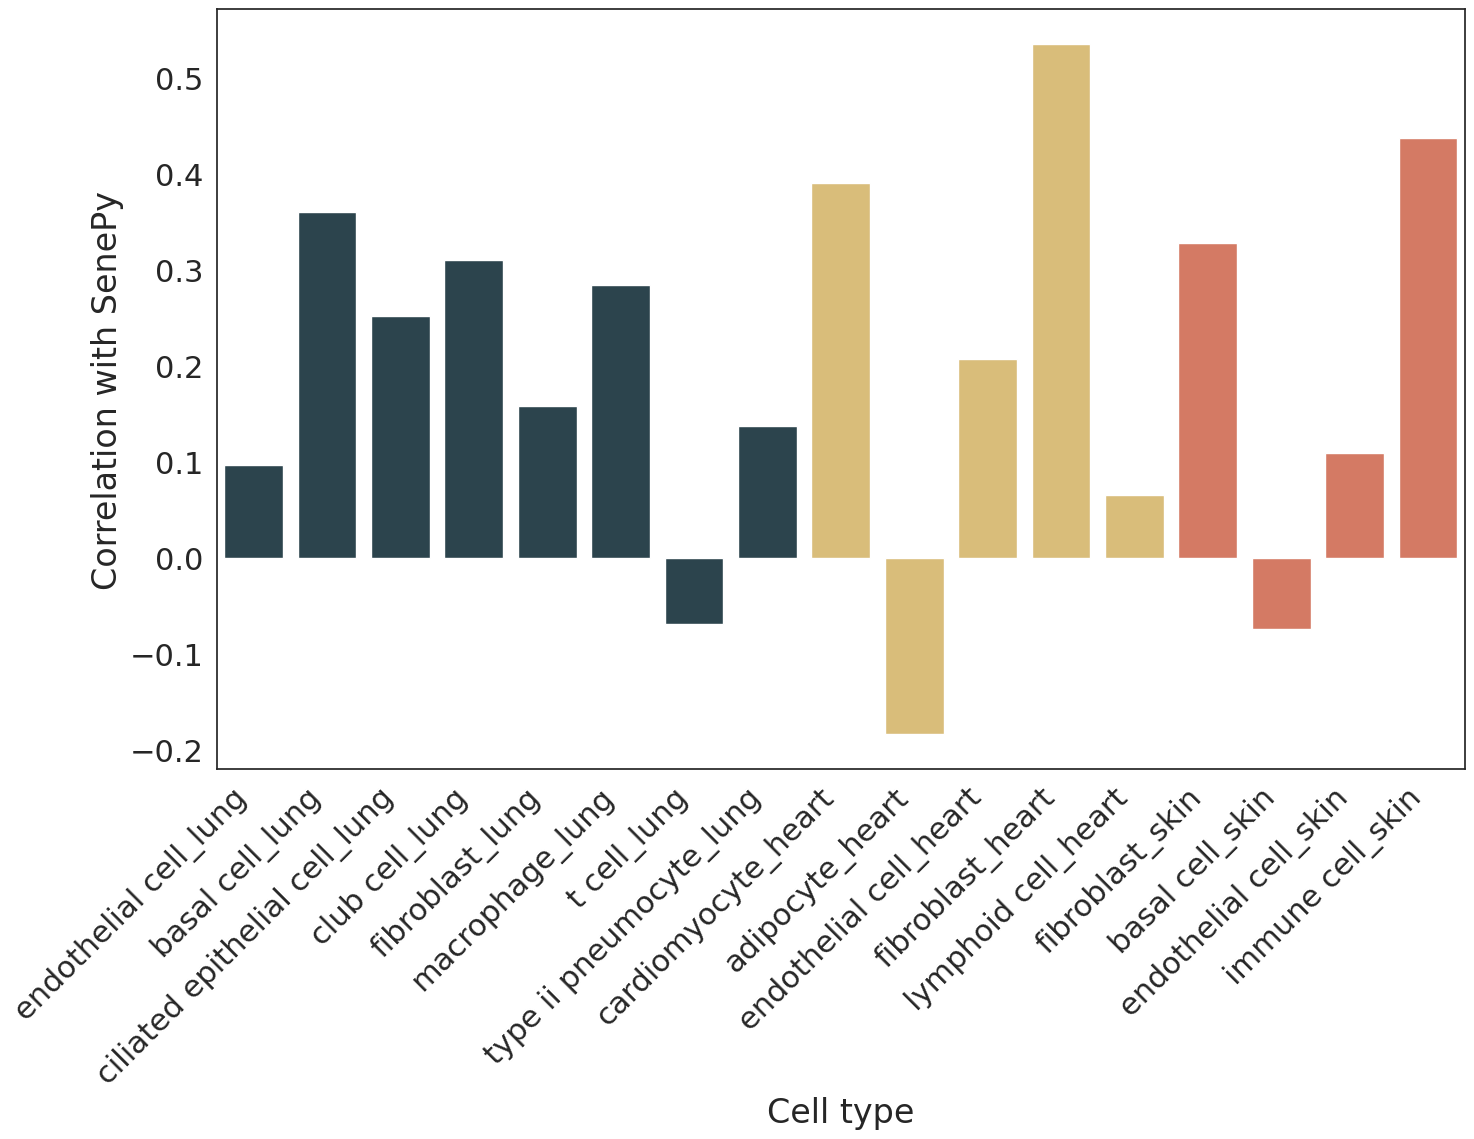

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=2,style='white')
plt.figure(figsize=(16,10))
sns.barplot(x='Cell type',y='Correlation',data=df_plot,ci=None,palette=['#264653']*8+['#e9c46a']*5+['#e76f51']*4)
plt.xticks(rotation=45,ha='right')
plt.ylabel('Correlation with SenePy')
plt.savefig("/home/wangjing/wangj/codebase/HUSI/Figures/model/valid_GTEx_SenePy.png",dpi = 300,bbox_inches = 'tight')